# Summary
___
We created a pipeline to extract, group, and label the data that is contained in the various event folders. We kept the data in the data frame format and grouped the rows by the key tuple: (event, lumi, run). After formatting the data that could be easily processed for machine learning, we tried various packages such as svm and random forest classifier. After tuning and and experimentation, during cross validation we classified events correctly at a proportion around .75. The next step is to optimize the processing code for space and time efficiency, and to start testing 3d convolution nets on the data. 




## Data Extraction and Preprocessing
___
The method process_container_folder() takes a directory string as the argument and extracts all numpy files contained in the lower level folders. 

In [2]:
import os
import numpy as np
import pandas as pd

def process_container_folder(folder):
    folder_paths = os.listdir(folder)
    folder_paths.pop(0)#Remove formatting file
    df = []
    index = 0
    for path in folder_paths:
        df.append(process_df_folder(folder + '/' + path, index))
        index += 1
    final_df = pd.concat(df)
    return final_df

def process_df_folder(folder, label):
    file_paths = os.listdir(folder)
    file_paths.pop(0)
    file_paths.remove('log')
    list_df = []
    for path in file_paths:
        total_path = folder + '/' + path
        df = pd.DataFrame(np.load(total_path))
        df['label'] = [label]*len(df)
        list_df.append(df) 
    final_df = pd.concat(list_df)
    return final_df

In [3]:
df = process_container_folder('cmsdata-2')
#df = pd.DataFrame.from_csv('processed_df.csv') #Here I chose to load preprocessed data rather than processing every time

The method sort_df_by_event() takes in the data frame, groups the data by the key tuple, and outputs a list of feature vectors and the list of their respective labels. The feature vector is created by sorting the rows of an event by 'pt' in ascending order then selecting only the first n rows. Then concatenating the remaining columns of data into a single column vector. If there were less rows than n rows we concatenated 0's to the end of the column vector to fit the appropriate length. Below is the general form of our feature vector:


| Feature Vector  |
| -------------   |
| **pt[0:n]**          | 
| **eta[0:n]**         |
| **phi[0:n]**         |
| **dxy[0:n]**         |
| **dz[0:n]**          |

In [4]:
FEATURES = 5
n = 15

def sort_df_by_event(df):
    df.sort_values(['lumi','evt','run'])
    gb = df.groupby(['lumi','evt','run'])
    train_x = []
    train_y = []
    vector = []
    for gp in gb:
        
        df = gp[1].sort_values('pt', ascending = 0)
        if len(df.index) >= n:
            df = df.head(n)
            vector = pd.concat([df['pt'],df['eta'], df['phi'], df['dxy'], df['dz']])

        else: 
            vector = pd.concat([df['pt'],df['eta'], df['phi'], df['dxy'], df['dz']])
            num_missing = n*FEATURES - len(vector)
            vector = vector.append(pd.Series([0]*num_missing))
            
        train_y.append(df['label'].iloc[0])
        train_x.append(vector)

    return train_x, train_y

In [5]:
x_data, y_data = sort_df_by_event(df)

## Data Analysis
We split the data for cross validation and run an svm and random forest classifier on the data.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.decomposition import PCA
import math

x_tr, x_tst, y_tr, y_tst = train_test_split(x_data, y_data, test_size=0.33, random_state=2)

In [7]:
clf_svm = svm.SVC(kernel = 'rbf', gamma = .001)
clf_rfc = RandomForestClassifier(n_estimators = 500)

In [8]:
clf_svm.fit(x_tr, y_tr)
clf_svm.score(x_tst,y_tst)

0.77141355754072516

In [9]:
clf_rfc.fit(x_tr, y_tr)
clf_rfc.score(x_tst,y_tst)

0.78139779295848655

We performed principal component analysis on the data and tried experimented with different sized basis but found nothing significant

Additionally we looked at the distribution of the features depending on the classification. 

In [10]:
df.sort_values(['lumi','evt','run'])
gb = df.groupby(['lumi','evt','run'])
avg_pt0 = []
avg_pt1 = []
avg_pt2 = []
avg_pt3 = []
metric = 'pt'
for gp in gb:
    event = gp[1]
    if event['label'].iloc[0] == 0:
        avg_pt0.append(event[metric].mean())
    if event['label'].iloc[0] == 1:
        avg_pt1.append(event[metric].mean())
    if event['label'].iloc[0] == 2:
        avg_pt2.append(event[metric].mean())
    if event['label'].iloc[0] == 3:
        avg_pt3.append(event[metric].mean())
print('Higgs ' + metric)
print('mean:', np.array(avg_pt0).mean())
print('std:', np.array(avg_pt0).std())
print('MuMu '+ metric)
print('mean:', np.array(avg_pt1).mean())
print('std:', np.array(avg_pt1).std())
print('QCD '+ metric)
print('mean:', np.array(avg_pt2).mean())
print('std:', np.array(avg_pt2).std())
print('Lepton ' + metric)
print('mean:', np.array(avg_pt3).mean())
print('std:', np.array(avg_pt3).std())

Higgs pt
mean: 2.93890530951
std: 3.52622481338
MuMu pt
mean: 0.969333638983
std: 0.203584342212
QCD pt
mean: 2.19465123453
std: 7.95507207809
Lepton pt
mean: 2.87762207567
std: 1.72434445085


Plotting the mean 'pt' of each event we can see that each event classification has a significantly different distribution, especially those of the JpsiMuMu classification which are in red.  

<IPython.core.display.Javascript object>


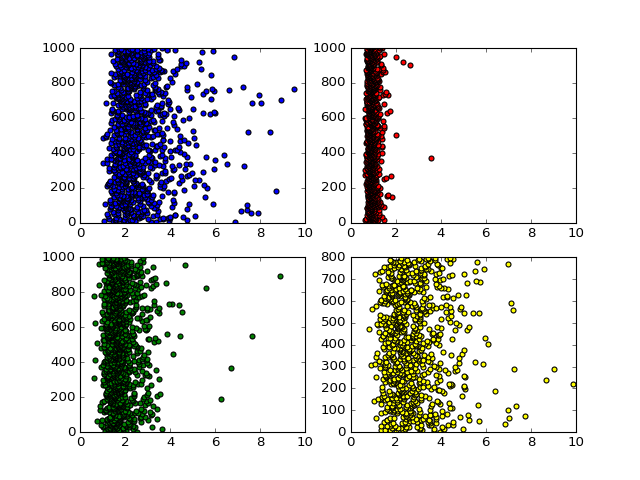

In [11]:
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt



fig, ((a,b),(c,d)) = plt.subplots(2,2)
a.axis([0,10,0,1000])
b.axis([0,10,0,1000])
c.axis([0,10,0,1000])
d.axis([0,10,0,800])
a.scatter(avg_pt0, range(0,len(avg_pt0)), c = 'blue')
b.scatter(avg_pt1, range(0,len(avg_pt1)), c = 'red')
c.scatter(avg_pt2, range(0,len(avg_pt2)), c = 'green')
d.scatter(avg_pt3, range(0,len(avg_pt3)), c = 'yellow')
